#Import Data from SQL

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import time
from collections import defaultdict
import nltk
import spacy
import logging 
from string import punctuation
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
%matplotlib inline

In [2]:
con = sqlite3.connect("/content/migrants_elections.db")

In [3]:
df = pd.read_sql("SELECT * FROM migrant_elections", con)

In [4]:
df.head()

,title,publication,date,text
0,PRICKLY TIES WITH MEXICO UNCERTAIN U.S. POLICY...,Chicago Tribune (pre-1997 Fulltext),"Dec 21, 1986",\r\n\r\nAs Mexico's problems worsen day by day...
1,"MAN GUILTY OF 4 RAPE ATTEMPTS: [SPORTS FINAL, ...",Chicago Tribune (pre-1997 Fulltext),"Dec 23, 1986",\r\n\r\nA man who was freed after an 82-year-o...
2,DEATH TOLL REACHES 11 IN REFUGEE BOAT MISHAP: ...,Chicago Tribune (pre-1997 Fulltext),"Dec 25, 1986",\r\n\r\nThe bodies of five illegal aliens wash...
3,"COST HIGH AS CHINESE SHIP KIDS: [SPORTS FINAL,...",Chicago Tribune (pre-1997 Fulltext),"Dec 25, 1986","\r\n\r\nShenzhen, set up to quicken China's ma..."
4,"PERSECUTION, POLITICS AND REFUGEES: [SPORTS FI...",Chicago Tribune (pre-1997 Fulltext),"Dec 4, 1986",\r\n\r\nIf July 4 was the warm-up for Miss Lib...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64217 entries, 0 to 64216
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        64217 non-null  object
 1   publication  64217 non-null  object
 2   date         64217 non-null  object
 3   text         64217 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


In [6]:
df['date']= pd.to_datetime(df['date'])

In [7]:
df.isna().sum()

title          0
publication    0
date           0
text           0
dtype: int64

In [8]:
import datetime
df['year'] = pd.DatetimeIndex(df['date']).year

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64217 entries, 0 to 64216
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        64217 non-null  object        
 1   publication  64217 non-null  object        
 2   date         64217 non-null  datetime64[ns]
 3   text         64217 non-null  object        
 4   year         64217 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.4+ MB


In [10]:
df2k = df[df['year'] >= 2000] 

In [11]:
df_small = df2k[(df2k['publication'] == 'Los Angeles Times') |
     (df2k['publication'] == 'New York Times') |
     (df2k['publication'] == 'Chicago Tribune') |
     (df2k['publication'] == 'The Washington Post') |
     (df2k['publication'] == 'New York Post') |
     (df2k['publication'] == 'USA TODAY') |
     (df2k['publication'] == 'Wall Street Journal')]

In [12]:
len(df_small)

42683

In [13]:
df_small['publication'].value_counts()

The Washington Post    11693
New York Times          9355
Los Angeles Times       8966
Chicago Tribune         6914
New York Post           2216
USA TODAY               2087
Wall Street Journal     1452
Name: publication, dtype: int64

#Topic Models

In [ ]:
df_small['original_index'] = np.arange(len(df_small))
bool_df = df_small['text'].duplicated(keep='first')
df_unique = df_small[~bool_df]
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41619 entries, 7902 to 59950
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           41619 non-null  object        
 1   publication     41619 non-null  object        
 2   date            41619 non-null  datetime64[ns]
 3   text            41619 non-null  object        
 4   year            41619 non-null  int64         
 5   original_index  41619 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_duplicate = df_small[bool_df]
len(df_duplicate)

1064

In [ ]:
len(df_unique)

41619

In [ ]:
df_unique['index'] = np.arange(len(df_unique))

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')


tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def pre_process(text):
  temp1 = ''.join(word for word in text if not word.isdigit())
  temp2 = tokenizer.tokenize(temp1)
  temp3 = [word.lower() for word in temp2 if word.lower() not in stopwords.words('english')]
  return temp3

In [ ]:
t = time()
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
vectoriser = CountVectorizer(analyzer=pre_process, max_df=0.95, min_df=0.01)
print('Vectorizer Created')
data = vectoriser.fit_transform(df_unique['text'])
print('Data Created')
features = vectoriser.get_feature_names()
print('Features Created')
print('Time to vectorise and create features: {} mins'.format(round((time() - t) / 60, 2)))

Vectorizer Created
Data Created
Features Created
Time to vectorise and create features: 66.41 mins


Perplexity 5-fold cross-validation with Scikit-Learn

In [ ]:
from scipy.sparse import vstack

In [ ]:
def perplexity_k_fold(corpus, start,limit,step,k=5):
  perplexity_values = []
  for num_topics in range(start, limit, step):
    print(f'Topic number',num_topics)
    temp_perplexity = []
    for fold in range(k):
      print(f'Processing fold', fold)
      val_data = corpus[num_val_samples * fold: num_val_samples * (fold + 1)]
      train1 = corpus[:num_val_samples * fold]
      train2 = data[num_val_samples * (fold + 1):]
      training_data = vstack([train1, train2]).toarray()
      del train1
      del train2
      #training_data = corpus[:num_val_samples * fold] + corpus[num_val_samples * (fold + 1):]
      model = LatentDirichletAllocation(learning_method='online',n_components=num_topics, n_jobs=-1, verbose=1, random_state=42)
      output = model.fit(training_data)
      del training_data
      temp_perplexity.append(output.perplexity(val_data))
      del val_data
    perplexity_values.append(np.average(temp_perplexity))
  return perplexity_values

In [ ]:
#with k-fold
t = time()
k = 5
num_val_samples = data.shape[0] // k
perplexity_values = perplexity_k_fold(corpus=data, start=10, limit=110, step=10, k=5)
print('Time to check different models: {} mins'.format(round((time() - t) / 60, 2)))

Cross-Validation with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV 
#Define Search Param
#search_params = {'n_components': [10,20,30,40,50,60,70,80,90,100], 'doc_topic_prior': [0.01, 0.03, 0.05, 0.1, 0.2]}
search_params = {'n_components': [10,20,30,40,50,60,70,80,90,100]}

In [ ]:
t = time()
class MyLDAWithPerplexityScorer(LatentDirichletAllocation):

    def score(self, X, y=None):

        # add perplexity to the cross-validation
        score = super(MyLDAWithPerplexityScorer, self).perplexity(X,sub_sampling=True)

        # turn perplexity into a negative number
        return -1*score
        
lda = MyLDAWithPerplexityScorer(max_iter=5, learning_method='online', learning_offset=50.,
                                random_state=1983,verbose=1)
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1,cv=5,refit = True,verbose=1)
model.fit(data)
print('Time to finish cross-validation: {} mins'.format(round((time() - t) / 60, 2)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 266.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 297.4min finished


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Time to finish cross-validation: 311.41 mins


In [ ]:
cv = pd.DataFrame(model.cv_results_)

In [ ]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,378.677597,7.152805,16.068406,0.782857,10,{'n_components': 10},-1936.620774,-2130.245602,-2057.533635,-1960.246825,-2080.547250,-2033.038817,73.350282,10
1,433.948810,7.584141,18.425565,1.209064,20,{'n_components': 20},-1833.709088,-1995.812133,-1914.020764,-1821.389403,-1916.254123,-1896.237102,63.472919,9
2,527.454237,8.461549,22.264257,1.406113,30,{'n_components': 30},-1793.800638,-1945.419971,-1859.316442,-1779.114475,-1877.738981,-1851.078101,60.230445,8
3,569.066823,8.824403,24.352088,1.667181,40,{'n_components': 40},-1758.116633,-1921.565767,-1841.552764,-1746.764782,-1850.378247,-1823.675639,64.542019,7
4,665.337424,12.086919,28.574026,2.006063,50,{'n_components': 50},-1746.651331,-1901.307091,-1818.646635,-1713.053362,-1825.923788,-1801.116442,65.852005,2
5,688.654844,16.867937,29.610124,1.984729,60,{'n_components': 60},-1745.932510,-1911.762336,-1825.242629,-1733.146606,-1838.202536,-1810.857323,65.407501,4
6,793.589433,15.249539,33.835313,2.889411,70,{'n_components': 70},-1754.276057,-1909.812367,-1805.854299,-1721.177190,-1798.317396,-1797.887462,63.839267,1
7,834.677972,17.137760,35.677950,2.761721,80,{'n_components': 80},-1741.500015,-1935.534194,-1817.053825,-1718.673219,-1824.266175,-1807.405486,76.172548,3
8,958.521057,17.878733,40.578799,3.341193,90,{'n_components': 90},-1753.753195,-1933.549778,-1824.316366,-1736.306934,-1809.713702,-1811.527995,69.357458,5
9,946.705904,82.915387,37.797147,6.417742,100,{'n_components': 100},-1755.986541,-1945.061496,-1821.271102,-1726.848908,-1831.807449,-1816.195099,75.476979,6


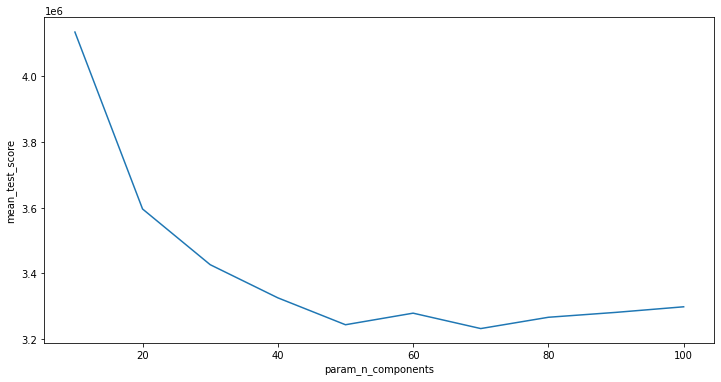

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x="param_n_components", y=cv['mean_test_score']**2, data=cv)

In [ ]:
!pip3 install kneed

In [ ]:
from kneed import KneeLocator
k = cv['param_n_components']
per = cv['mean_test_score']**2
k = pd.to_numeric(k)
per = pd.to_numeric(per)
kn = KneeLocator(k, per, curve='convex', direction='decreasing')
kn.knee

40

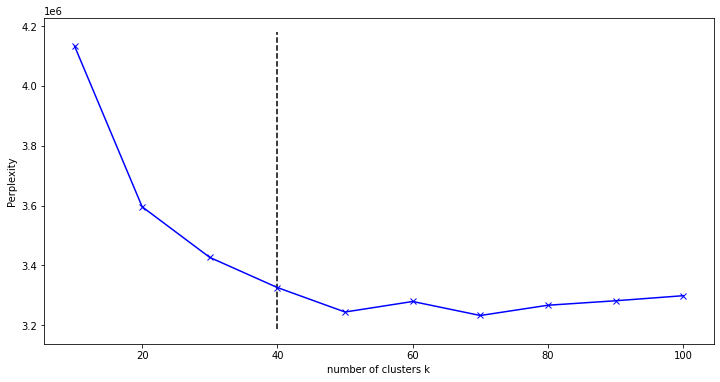

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel('number of clusters k')
plt.ylabel('Perplexity')
plt.plot(k, per, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [ ]:
lda_model = LatentDirichletAllocation(learning_method='online',n_components=40,n_jobs=-1,verbose=1,random_state = 42)
lda_output = lda_model.fit_transform(data)
print(lda_model)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=1)


Gensim per despres

In [ ]:
def compute_coherence_values_k_fold(dictionary, corpus, texts, limit, start=2, step=3, k=5):
    perplexity_values= []
    for num_topics in range(start, limit, step):
      temp_perplexity = []
      for fold in range(k):
        print(f'processing fold', fold)
        val_data = corpus[num_val_samples * fold: num_val_samples * (fold + 1)]
        training_data = corpus[:num_val_samples * fold] + common_corpus[num_val_samples * (fold + 1):]
        model = LdaModel(corpus=training_data, num_topics=num_topics,id2word=common_dictionary)
        temp_perplexity.append(model.log_perplexity(val_data))
      perplexity_values.append(temp_perplexity)
    return perplexity_values

In [ ]:
#with k-fold
t = time()
num_val_samples = len(common_corpus) // k
perplexity_values = compute_coherence_values_k_fold(dictionary=common_dictionary, 
                                                    corpus=common_corpus, texts=df_unique['text_clean'], 
                                                    start=10, limit=30, step=10, k=5)
print('Time to check different models: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " has Perplexity Value of", round(2**-(cv), 4))

Save the model

In [ ]:
!pip3 install joblib

In [ ]:
import joblib

In [ ]:
joblib.dump(lda_model, 'lda_model_migrants.2000.2016.jl')

['lda_model_migrants.2000.2016.jl']

In [ ]:
joblib.dump(lda_output, 'lda_output.2000.2016.jl')

['lda_output.2000.2016.jl']

In [ ]:
# then reload it with
lda_model = joblib.load('lda_model_migrants.2000.2016.jl')

In [ ]:
theta = pd.DataFrame(lda_output)
theta['index'] = np.arange(len(theta))
print(len(theta))
meta_theta_df = df_unique.join(theta, how='left', on='index', rsuffix = '_theta')

41619


In [ ]:
mybeta = pd.DataFrame(lda_model.components_)
mybeta.columns = features
mybeta = mybeta.transpose()
#mybeta = np.exp(mybeta)

In [ ]:
len(mybeta)

5787

In [ ]:
nwords = 50

topwords = []
for i in range(0,40,1):
  tempframe = mybeta[i].sort_values(ascending=False)
  tempframe = tempframe[1:nwords]
  #tempvec = tempframe.index.values
  topwords.append(tempframe.index.values)

topwords = pd.DataFrame(topwords).T
topwords.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,law,hispanic,said,first,said,free,department,marriage,angeles,president,military,house,said,muslim,immigrants,europe,care,students,free,maryland,united,search,new,street,company,city,one,film,airport,party,mexican,miami,bush,house,said,charges,campaign,said,police,family
1,justice,rubio,enforcement,jump,patrol,center,would,gay,california,barack,israel,former,like,attacks,illegal,britain,help,schools,st,prince,said,term,said,th,says,people,like,com,flight,president,u,cuban,president,senate,ms,prosecutors,republican,work,officers,church
2,case,black,federal,new,migrants,library,officials,sex,times,russian,iraq,president,back,muslims,said,party,needs,said,www,gang,states,turn,year,york,million,community,even,show,air,republicans,de,cuba,hillary,would,new,court,state,labor,two,children
3,supreme,american,law,university,mexico,rd,said,gun,said,russia,jewish,washington,two,islamic,would,france,tax,education,museum,william,government,said,people,avenue,chinese,mayor,think,music,coast,would,fox,gonzalez,donald,said,york,trial,party,jobs,authorities,father
4,judge,said,officials,team,agents,volunteers,federal,violence,san,first,u,committee,says,said,citizenship,minister,medical,high,saturday,washington,country,text,population,west,market,group,would,movie,beach,conservative,spanish,said,gore,r,photograph,prison,said,job,man,mother


In [ ]:
text_theta = theta.join(df_unique['text'], how='right',on='index')
text_theta = text_theta.set_index('text')

In [ ]:
ntext = 30

toptexts=[]
for i in range(0,40,1):
  tempframe = text_theta.sort_values(i,ascending=False)
  tempframe = tempframe[1:ntext]
  toptexts.append(tempframe.index.values)
  

toptexts = pd.DataFrame(toptexts).T

toptexts.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,\r\n\r\nPUBLISHED CORRECTIONS: A March 26 Metr...,A NON PROFIT fund- ed with hundreds of thousan...,It is one hour into Farhang Holakouee's daytim...,As the new supervisor of the Angeles National ...,\r\n\r\nAt St. Anne Catholic Church in Santa M...,Caption text only.\r\n\r\n*Illustration*\r\n\r...,A lot of folks would like the Elian Gonzalez c...,"\r\n\r\nThe September Fund, a new independent ...",\r\n\r\nHealth Net of California is expected t...,\r\n\r\nFederal voting-rights enforcers Monday...,Bouncing from issues of foreign policy to stat...,\r\n\r\nCOULD this be the same Republican Part...,WASHINGTON - Operation Protect Elian has cost ...,"Vicente Fox, Mexico's newly elected president,...","\r\n\r\nAmid a sea of 10,000 immigrants marchi...",\r\n\r\nNATION\r\n\r\nThe government on Thursd...,The United States must increase pressure on Me...,\r\n\r\nHundreds of demonstrators gathered in ...,"With the race for the White House grown tight,...",A Montebello woman earlier charged with defrau...,\r\n\r\n \r\n\r\nPresident Obama's State of th...,Full Text\r\n\r\nTurn on search term navigatio...,"For Antonio Alarcon, 18, who emigrated from Me...",\r\n\r\n \r\n\r\nIS the popular Global Entry p...,\r\n\r\nVoters in Democratic-leaning Arlington...,\r\n\r\nVirginians elected Democrat Timothy M....,\r\n\r\nWhen 30-year-old Jose Bermudez abandon...,\r\n\r\n \r\n\r\nPresident Barack Obama is tre...,\r\n\r\n \r\n\r\nEven after receiving a medica...,Ahmed Mostafa and his friends paid thousands o...,Full Text\r\n\r\nTurn on search term navigatio...,\r\n\r\nWHEN Cresskill School District officia...,\r\n\r\nThe 41-year-old American teacher arres...,\r\n\r\nThe American authorities have seized $...,\r\n\r\n \r\n\r\nWith untold numbers of immigr...,\r\n\r\nMexican election officials came to Chi...,"Four dozen ancient Peruvian artifacts, includi...",\r\n\r\n \r\n\r\nSen. Marco Rubio has got it r...,"Early in his career, Julio Iglesias sang about...",\r\n\r\nIt's a bit like Napster -- but for pol...
1,CAMPAIGN 2000.\r\n\r\nWith a school map in one...,Full Text\r\n\r\nTurn on search term navigatio...,"President Thomas Klestil, who brought calm to ...",\r\n\r\nHundreds of thousands of demonstrators...,\r\n\r\nNATION\r\n\r\nCaught in a scheduling s...,"I applaud the Bush administration's new ""exped...",\r\n\r\nTensions over immigration policy erupt...,A veteran Aurora police officer who was indict...,\r\n\r\nThey didn't hug. They didn't kiss. The...,\r\n\r\nWhile several other French cities were...,\r\n\r\n \r\n\r\nDespite days of huddling behi...,Former Federal Reserve Chairman Alan Greenspan...,\r\n\r\nAn Indian man convicted in the U.S. of...,More than 500 Mexican immigrants arrived at a ...,Full Text\r\n\r\nTurn on search term navigatio...,The searing pain in Ana Margarita Lucero-Garci...,Following a series of missteps and embarrassin...,\r\n\r\nDrawing on fear of restrictive immigra...,Lured by the promise of wealth in a booming ec...,In a development that may expand the legal sco...,Authorities captured 13 suspected illegal immi...,"Re ""Progress in Pakistan,"" editorial, Feb. 20\...",WASHINGTON - Homeland Security boss Janet Napo...,\r\n\r\n \r\n\r\nGeorge W. Bush was president ...,Expelled Cuban diplomat Jose Imperatori may be...,\r\n\r\nCHICAGO\r\n\r\nA Mexican crime boss wh...,Stop Me If You've Heard This\r\n\r\nA History ...,\r\n\r\nThe federal government turned their li...,\r\n\r\nThe federal government hailed the conv...,California's labor market continued its slow i...,Benetton has come up with a unique way to expr...,"For 29-year-old Lorena Dominguez, the San Fern...",Despite concerns that anti-welfare fraud measu...,"\r\n\r\nBefore the sun has risen, while most p...",Let me bring you up to date on some offerings ...,\r\n\r\nUnder pressure from Republicans to pla...,Jack Ratusch knew something was amiss when he ...,The Isra

In [ ]:
mybeta = pd.DataFrame(lda_model.components_)
mybeta.columns = features
mybeta = mybeta.transpose()
#mybeta = np.exp(mybeta)

myw = 0.3
word_beta_sum = np.sum(mybeta, axis=1)
mybeta_for_frex = mybeta
columns = list(mybeta_for_frex)
df_range = len(mybeta_for_frex)
for m in columns:
  for n in range(df_range):
    mybeta_for_frex.iloc[n][m] = 1/(myw/(mybeta_for_frex.iloc[n][m]/word_beta_sum.iloc[n])+((1-myw)/mybeta_for_frex.iloc[n][m]))
  #print(m)

nwords = 50

topwordsFREX = []
for i in range(0,40,1):
  tempframe = mybeta_for_frex[i].sort_values(ascending=False)
  tempframe = tempframe[1:nwords]
  #tempvec = tempframe.index.values
  topwordsFREX.append(tempframe.index.values)

topwordsFREX = pd.DataFrame(topwordsFREX).T
topwordsFREX.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,upheld,whites,inmates,bernie,paso,fridays,database,gay,californians,barack,israel,confirmation,cruz,mitt,legalization,european,loans,graduation,ave,gang,refugees,newsletter,median,galleries,hong,marches,commentary,broadway,terminal,deficit,vicente,cuban,mcconnell,hastert,mrs,verdict,huckabee,applicants,homicide,priest
1,unconstitutional,asians,detain,cleveland,patrol,wednesdays,accountability,sex,bernardino,putin,iraqi,lobbyist,chicken,qaeda,citizenship,eu,uninsured,classrooms,tours,prince,canada,search,housing,archives,investors,protesters,uncomfortable,paintings,rico,midterm,lopez,cuba,rodham,reid,ms,sentencing,candidacy,wages,detectives,bishop
2,supreme,blacks,detention,basketball,crossings,thursdays,technologies,couples,sacramento,vladimir,palestinians,ethics,beer,mosque,undocumented,parliament,clinics,literacy,www,gangs,passport,text,census,staten,kong,marched,ridiculous,comedy,ferry,agenda,mexicans,castro,clinton,schumer,giuliani,trial,ballots,overtime,cops,congregation
3,judges,hispanics,raids,springfield,tucson,saturdays,homeland,contains,angeles,moscow,civilians,edwards,thick,bin,amnesty,austria,medicaid,teachers,exhibit,prisons,australia,turn,borough,harlem,products,organizer,surely,theaters,airlines,conservatism,mexican,reno,hillary,senators,photograph,guilty,incumbent,employer,robbery,funeral
4,lawsuit,hispanic,profiling,football,smuggling,sundays,transit,gays,uc,deferred,soldiers,advisory,legs,mohammed,guest,dutch,nurses,educators,se,maryland,refugee,ted,households,sculpture,entrepreneurs,demonstrators,writes,musical,islands,conservatives,hernandez,cubans,cheney,provisions,rudolph,prosecutors,challenger,wage,sentenced,orthodox


In [ ]:
toptexts.to_excel('toptexts.2000.2016.xlsx', index = False)
topwords.to_excel('topwords.2000.2016.xlsx',index = False)
topwordsFREX.to_excel('topwordsFREX.2000.2016.xlsx',index = False)

In [ ]:
lda_model = joblib.load('lda_model_migrants.2000.2016.jl')
lda_output = joblib.load('lda_output.2000.2016.jl')

In [ ]:
theta = pd.DataFrame(lda_output)
theta['index'] = np.arange(len(theta))
meta_theta_df = df_unique.join(theta, how='left', on='index', rsuffix = '_theta')

In [ ]:
meta_theta_df.to_excel('meta_theta_df.2000.2016.xlsx',index = False)

#Word Embeddings

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])

In [ ]:
df00 = df_small[df_small['year'] == 2000]

In [ ]:
len(df00)

7247

In [ ]:
lower_casing = (row.lower() for row in df00['text'])

In [ ]:
def cleaning_lem(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.5 mins


In [ ]:
df00['text'].iloc[0]

'SPECIAL SECTION. Employment Outlook.\r\n\r\nAfter more than a decade of flying, Anne Carter\'s enthusiasm for\r\nclimbing into those Delta Air Lines jets was beginning to lag.\r\n\r\nA mother of two children, Carter liked her work as a flight attendant,\r\nbut she wanted more time with her kids. She wanted more control over her\r\nschedule. "I got real tired of never having a choice of when I flew or\r\nwhere," Carter recalls.\r\n\r\nSo, four years ago, Carter started something new: She began learning French.\r\n\r\n"I loved international (flights), and I knew that if I wanted to have a\r\nchoice and have weekends and holidays off, I needed a language," she said.\r\n\r\nUpon passing the airline\'s French test, Carter leaped ahead of her\r\nmonolingual peers. "Everything is done by seniority," the 21-year Delta\r\nveteran said. "It gives me about a 10-year advantage."\r\n\r\nCarter says she has spent at least $6,000 for French lessons and an\r\nimmersion program in which she took off f

In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(7210, 1)


                                               clean
0  special section employment outlook \r\n\r\n de...
1  cluster high rise know frankfurter manhattan \...
2  favorite holiday memory \r\n\r\n hesitate writ...
3  gallop growth south west drive u.s population ...
4  cuba wednesday dismiss new report panel \r\n a...


In [ ]:
df_clean['clean'].iloc[0]

'special section employment outlook \r\n\r\n decade flying anne carter enthusiasm \r\n climb delta air line jet begin lag \r\n\r\n mother child carter like work flight attendant \r\n want time kid want control \r\n schedule get real tired have choice fly \r\n carter recall \r\n\r\n year ago carter start new begin learn french \r\n\r\n love international flight know want \r\n choice weekend holiday need language say \r\n\r\n pass airline french test carter leap ahead \r\n monolingual peer seniority 21-year delta \r\n veteran say give 10-year advantage \r\n\r\n carter say spend $ french lesson \r\n immersion program take work spend month nice \r\n\r\n worth franc say virtually pick \r\n choose schedule want spend time child \r\n plus depend hour fly money \r\n say international excursion \r\n\r\n parlez -vous francais \r\n\r\n worker say yes french \r\n german spanish mandarin chinese language say evelyne \r\n feltz director atlanta office lingua \r\n international language training orga

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=100)

In [ ]:
bigram = Phraser(phrases)

INFO - 22:54:24: source_vocab length 1914982
INFO - 22:54:44: Phraser built with 2381 phrasegrams


In [ ]:
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

79629

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'year', 'people', 'mr', '$', 'state', 'time', 'work', 'new', 'child']

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count()
cores

2

In [ ]:
w2v_model00 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model00.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model00.train(sentences, total_examples=w2v_model00.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model00.init_sims(replace=True)

INFO - 23:06:20: precomputing L2-norms of word weight vectors


In [ ]:
similar_words00 = {search_term: [item for item in w2v_model00.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
similar_words00

{'america': [('americans', 0.5524606108665466),
  ('american', 0.5144453644752502),
  ('american_dream', 0.5125854015350342),
  ('god_bless', 0.49586111307144165),
  ('21st_century', 0.4953190088272095)],
 'border': [('border_crossing', 0.6973053216934204),
  ('u.s.-mexico_border', 0.6941225528717041),
  ('crosser', 0.6464669704437256),
  ('border_patrol', 0.6299538016319275),
  ('crossing', 0.6264858245849609)],
 'immigrant': [('latino_immigrant', 0.6209702491760254),
  ('new_arrival', 0.5939366221427917),
  ('newcomer', 0.5905730128288269),
  ('illegal_immigrant', 0.5786904096603394),
  ('bosnians', 0.5285717248916626)],
 'latino': [('latinos', 0.797261118888855),
  ('hispanic', 0.7646895051002502),
  ('latino_community', 0.6749190092086792),
  ('hispanics', 0.6226878762245178),
  ('latino_voter', 0.6173049211502075)],
 'law': [('immigration_law', 0.6482850909233093),
  ('statute', 0.6295552253723145),
  ('rule', 0.5800313353538513),
  ('law_require', 0.5720314383506775),
  ('federal

In [ ]:
w2v_model00.wv.similarity("immigrant", 'undocumented')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.42859426

In [ ]:
pd.DataFrame(similar_words00)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(latino_immigrant, 0.6209702491760254)","(asylum_seeker, 0.7206614017486572)","(united_state, 0.853642463684082)","(immigration_law, 0.6482850909233093)","(americans, 0.5524606108665466)","(muslims, 0.7959645986557007)","(mexican, 0.7762179374694824)","(latinos, 0.797261118888855)","(border_crossing, 0.6973053216934204)"
1,"(new_arrival, 0.5939366221427917)","(unhcr, 0.6395756006240845)","(u.s, 0.7508399486541748)","(statute, 0.6295552253723145)","(american, 0.5144453644752502)","(islamic, 0.7391312122344971)","(mexicans, 0.6579406261444092)","(hispanic, 0.7646895051002502)","(u.s.-mexico_border, 0.6941225528717041)"
2,"(newcomer, 0.5905730128288269)","(refugees, 0.6162595748901367)","(country, 0.6597697734832764)","(rule, 0.5800313353538513)","(american_dream, 0.5125854015350342)","(islam, 0.6897661685943604)","(mr_fox, 0.6551897525787354)","(latino_community, 0.6749190092086792)","(crosser, 0.6464669704437256)"
3,"(illegal_immigrant, 0.5786904096603394)","(asylum, 0.5984674096107483)","(usa, 0.5457584857940674)","(law_require, 0.5720314383506775)","(god_bless, 0.49586111307144165)","(mosque, 0.6702099442481995)","(fox, 0.6108071804046631)","(hispanics, 0.6226878762245178)","(border_patrol, 0.6299538016319275)"
4,"(bosnians, 0.5285717248916626)","(iraqis, 0.596623420715332)","(homeland, 0.48055243492126465)","(federal_law, 0.568639874458313)","(21st_century, 0.4953190088272095)","(saeed, 0.6196926236152649)","(guadalajara, 0.5957913994789124)","(latino_voter, 0.6173049211502075)","(crossing, 0.6264858245849609)"


In [ ]:
df04 = df_small[df_small['year'] == 2004]

In [ ]:
len(df04)

6281

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df04['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.68 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(6224, 1)


                                               clean
0  immigration judge wednesday order deportation ...
1  far walk vote november presidential \r\n elect...
2  foreign consulate hindu buddhist temple tsunam...
3  john b. rackos proud hellene proud family man ...
4  chris takaishi devour food court sushi mall be...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 'year',
 '$',
 'mr',
 'people',
 'work',
 'immigrant',
 'time',
 'new',
 'state']

In [ ]:
w2v_model04 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model04.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model04.train(sentences, total_examples=w2v_model04.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model04.init_sims(replace=True)

INFO - 23:19:55: precomputing L2-norms of word weight vectors


In [ ]:
similar_words04 = {search_term: [item for item in w2v_model04.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law', 'america','muslim','mexico','latino','border']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
similar_words04

{'america': [('americans', 0.5359286069869995),
  ('patriotism', 0.5121691226959229),
  ('american_dream', 0.501049816608429),
  ('freedom', 0.500280499458313),
  ('john_kerry', 0.4937852919101715)],
 'border': [('u.s.-mexico_border', 0.7483950257301331),
  ('border_crossing', 0.69188392162323),
  ('crossing', 0.6564171314239502),
  ('cross_border', 0.6261504292488098),
  ('port_entry', 0.5862184166908264)],
 'immigrant': [('newcomer', 0.5591698884963989),
  ('illegal_immigrant', 0.5527785420417786),
  ('undocumented_immigrant', 0.5240035057067871),
  ('mexican_immigrant', 0.4938681423664093),
  ('grow_number', 0.48774608969688416)],
 'latino': [('hispanic', 0.7705554962158203),
  ('latinos', 0.7177085876464844),
  ('latino_community', 0.6551494002342224),
  ('mexican_american', 0.6054165363311768),
  ('hispanics', 0.5905544757843018)],
 'law': [('statute', 0.6671440601348877),
  ('law_require', 0.6307257413864136),
  ('rule', 0.6252115964889526),
  ('immigration_law', 0.59323918819427

In [ ]:
pd.DataFrame(similar_words04)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(newcomer, 0.5591698884963989)","(resettlement, 0.7001038193702698)","(united_state, 0.8307098150253296)","(statute, 0.6671440601348877)","(americans, 0.5359286069869995)","(muslims, 0.7841423153877258)","(mexican, 0.7397723197937012)","(hispanic, 0.7705554962158203)","(u.s.-mexico_border, 0.7483950257301331)"
1,"(illegal_immigrant, 0.5527785420417786)","(asylum_seeker, 0.6530070304870605)","(u.s, 0.7177536487579346)","(law_require, 0.6307257413864136)","(patriotism, 0.5121691226959229)","(islamic, 0.7439464926719666)","(mexico_city, 0.6838058233261108)","(latinos, 0.7177085876464844)","(border_crossing, 0.69188392162323)"
2,"(undocumented_immigrant, 0.5240035057067871)","(asylum, 0.6035252809524536)","(country, 0.7072908878326416)","(rule, 0.6252115964889526)","(american_dream, 0.501049816608429)","(muslim_community, 0.6849849820137024)","(mexicans, 0.6539533138275146)","(latino_community, 0.6551494002342224)","(crossing, 0.6564171314239502)"
3,"(mexican_immigrant, 0.4938681423664093)","(humanitarian, 0.5884792804718018)","(usa, 0.5302191972732544)","(immigration_law, 0.5932391881942749)","(freedom, 0.500280499458313)","(islam, 0.6742896437644958)","(puebla, 0.570092499256134)","(mexican_american, 0.6054165363311768)","(cross_border, 0.6261504292488098)"
4,"(grow_number, 0.48774608969688416)","(persecution, 0.561942458152771)","(enter_u.s, 0.5010650157928467)","(constitutional, 0.5851207971572876)","(john_kerry, 0.4937852919101715)","(muslim_cleric, 0.6196419596672058)","(central_america, 0.5648458003997803)","(hispanics, 0.5905544757843018)","(port_entry, 0.5862184166908264)"


In [ ]:
w2v_model04.wv.similarity("immigrant", 'undocumented')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.41409898

In [ ]:
df05 = df_small[df_small['year'] == 2005]

In [ ]:
len(df05)

2940

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df05['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.77 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(2902, 1)


                                               clean
0  \r\n\r\n gov arnold schwarzenegger plan specia...
1  \r\n\r\n case spotlight horrific condition dis...
2  \r\n\r\n riverside activist wednesday announce...
3  \r\n\r\n special order editorial april wrong r...
4  \r\n\r\n need manicure pico boulevard west dow...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 'year',
 'people',
 'work',
 'u.s',
 'mr',
 'immigration',
 'official',
 '$',
 'state']

In [ ]:
w2v_model05 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model05.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model05.train(sentences, total_examples=w2v_model05.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model05.init_sims(replace=True)

INFO - 23:26:45: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model05.wv.most_similar(positive=["immigrant"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('newcomer', 0.6168614625930786),
 ('undocumented_immigrant', 0.5921840667724609),
 ('illegal_immigrant', 0.55466628074646),
 ('undocumented', 0.5158336162567139),
 ('foreign_bear', 0.4888349771499634),
 ('haitians', 0.47398266196250916),
 ('migrant', 0.4716896414756775),
 ('arrival', 0.47048601508140564),
 ('resident', 0.46549877524375916),
 ('latinos', 0.4626820683479309)]

In [ ]:
similar_words05 = {search_term: [item for item in w2v_model05.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
similar_words05

{'america': [('americans', 0.4085319936275482),
  ('american', 0.4070231318473816),
  ('delhi', 0.39383888244628906),
  ('world', 0.38653525710105896),
  ('latin_america', 0.38124287128448486)],
 'border': [('mexican_border', 0.7233519554138184),
  ('border_crossing', 0.6035482287406921),
  ('border_patrol', 0.6019190549850464),
  ('secure_border', 0.59304279088974),
  ('arizona', 0.5908503532409668)],
 'immigrant': [('newcomer', 0.6168614625930786),
  ('undocumented_immigrant', 0.5921840667724609),
  ('illegal_immigrant', 0.55466628074646),
  ('undocumented', 0.5158336162567139),
  ('foreign_bear', 0.4888349771499634)],
 'latino': [('hispanic', 0.7080506086349487),
  ('latinos', 0.6604240536689758),
  ('hispanics', 0.6119866371154785),
  ('latino_community', 0.5550426244735718),
  ('munoz', 0.5233376622200012)],
 'law': [('immigration_law', 0.5966293215751648),
  ('statute', 0.5441206693649292),
  ('precedent', 0.5080759525299072),
  ('busing', 0.5015708208084106),
  ('guideline', 0.4

In [ ]:
pd.DataFrame(similar_words05)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(newcomer, 0.6168614625930786)","(resettlement, 0.7034099698066711)","(united_state, 0.7575693130493164)","(immigration_law, 0.5966293215751648)","(americans, 0.4085319936275482)","(muslims, 0.6865794658660889)","(mexican, 0.6919969320297241)","(hispanic, 0.7080506086349487)","(mexican_border, 0.7233519554138184)"
1,"(undocumented_immigrant, 0.5921840667724609)","(resettle, 0.6795063018798828)","(u.s, 0.57827228307724)","(statute, 0.5441206693649292)","(american, 0.4070231318473816)","(muslim_community, 0.6652344465255737)","(mexicans, 0.6499365568161011)","(latinos, 0.6604240536689758)","(border_crossing, 0.6035482287406921)"
2,"(illegal_immigrant, 0.55466628074646)","(persecution, 0.5562364459037781)","(country, 0.5535442233085632)","(precedent, 0.5080759525299072)","(delhi, 0.39383888244628906)","(islamic, 0.6563736796379089)","(mexico_city, 0.6127292513847351)","(hispanics, 0.6119866371154785)","(border_patrol, 0.6019190549850464)"
3,"(undocumented, 0.5158336162567139)","(grant_asylum, 0.5392768383026123)","(abroad, 0.5360440015792847)","(busing, 0.5015708208084106)","(world, 0.38653525710105896)","(islam, 0.636600136756897)","(mexican_government, 0.5606302618980408)","(latino_community, 0.5550426244735718)","(secure_border, 0.59304279088974)"
4,"(foreign_bear, 0.4888349771499634)","(united_nations, 0.5303472280502319)","(enter_country, 0.5271936058998108)","(guideline, 0.4622150957584381)","(latin_america, 0.38124287128448486)","(extremism, 0.576684296131134)","(fox, 0.5435117483139038)","(munoz, 0.5233376622200012)","(arizona, 0.5908503532409668)"


In [ ]:
df06 = df_small[df_small['year'] == 2006]
len(df06)

4441

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df06['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.4 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(4398, 1)


                                               clean
0  \r\n\r\n tribune staff reporter susan kuczka j...
1  \r\n\r\n screen \r\n\r\n richard linklater fas...
2  \r\n\r\n money weekly guide personal finance \...
3  \r\n\r\n talk business \r\n\r\n hundred thousa...
4  \r\n\r\n nationalism rise russia appear \r\n p...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
w2v_model06 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model06.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model06.train(sentences, total_examples=w2v_model06.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model06.init_sims(replace=True)

INFO - 23:35:49: precomputing L2-norms of word weight vectors


In [ ]:
similar_words06 = {search_term: [item for item in w2v_model06.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
pd.DataFrame(similar_words06)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(undocumented_immigrant, 0.6192390322685242)","(resettlement, 0.7356830835342407)","(united_state, 0.7957003712654114)","(rule, 0.6412621736526489)","(assimilate, 0.565172553062439)","(muslims, 0.8101866245269775)","(mexicans, 0.6707909107208252)","(latinos, 0.785356342792511)","(southern_border, 0.7789376974105835)"
1,"(illegal_immigrant, 0.5921577215194702)","(resettle, 0.6634875535964966)","(u.s, 0.6588611602783203)","(immigration_law, 0.6085965633392334)","(nation, 0.5200099945068359)","(islamic, 0.6987923383712769)","(mexican, 0.5887833833694458)","(hispanic, 0.7433797717094421)","(mexican_border, 0.7255388498306274)"
2,"(undocumented, 0.5878487825393677)","(burmese, 0.6623342633247375)","(country, 0.5476547479629517)","(regulation, 0.566287636756897)","(isolationism, 0.505120038986206)","(islam, 0.6318005323410034)","(mr_fox, 0.5489879846572876)","(latino_community, 0.6948388814926147)","(u.s.-mexico_border, 0.6809314489364624)"
3,"(latinos, 0.5358006954193115)","(hmong, 0.6501950621604919)","(usa, 0.5318757891654968)","(guideline, 0.5591002106666565)","(ideal, 0.48196613788604736)","(extremist, 0.6218851208686829)","(zacatecas, 0.5267625451087952)","(hispanics, 0.665122389793396)","(frontier, 0.6372125744819641)"
4,"(undocumented_worker, 0.49330341815948486)","(myanmar, 0.6007257699966431)","(enter_country, 0.5066897869110107)","(law-, 0.527107298374176)","(american_dream, 0.4807897210121155)","(islamophobia, 0.6161925792694092)","(create_job, 0.5190111994743347)","(spanish_speak, 0.5739312171936035)","(u.s.-mexican_border, 0.5927503108978271)"


In [ ]:
df08 = df_small[df_small['year'] == 2008]
len(df08)

6369

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df08['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.74 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(6204, 1)


                                               clean
0  samuel huntington influential harvard politica...
1  rep rahm emanuel d ill incoming chief staff pr...
2  theresa coghlan sit west church sunday \r\n gr...
3  fire dead mourn \r\n\r\n dozen liberian immigr...
4  pennsylvania \r\n\r\n movie theater rage lead ...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
w2v_model08 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model08.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model08.train(sentences, total_examples=w2v_model08.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model08.init_sims(replace=True)

INFO - 23:49:38: precomputing L2-norms of word weight vectors


In [ ]:
similar_words08 = {search_term: [item for item in w2v_model08.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

In [ ]:
pd.DataFrame(similar_words08)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(illegal_immigrant, 0.577490508556366)","(resettlement, 0.7240615487098694)","(united_state, 0.7903025150299072)","(statute, 0.6683027744293213)","(american_dream, 0.5603734254837036)","(muslims, 0.8024026155471802)","(mexican, 0.7358221411705017)","(hispanic, 0.785427451133728)","(mexican_border, 0.7133705019950867)"
1,"(foreign_bear, 0.5265228748321533)","(resettle, 0.7026286125183105)","(u.s, 0.7232416868209839)","(rule, 0.6171911954879761)","(world, 0.48652806878089905)","(islam, 0.7097618579864502)","(mexico_city, 0.6953983306884766)","(latinos, 0.7728993892669678)","(u.s.-mexico_border, 0.6909787654876709)"
2,"(undocumented_immigrant, 0.5044801235198975)","(iraqi_refugee, 0.6776788234710693)","(abroad, 0.598203182220459)","(federal_law, 0.590126633644104)","(sacrifice, 0.48573875427246094)","(islamic, 0.6610182523727417)","(cross_border, 0.6447737812995911)","(latino_community, 0.6797577142715454)","(crosser, 0.6898342370986938)"
3,"(immigration, 0.4786641001701355)","(iraqis, 0.6431382894515991)","(country, 0.5842535495758057)","(law_require, 0.5747992992401123)","(ideal, 0.484653115272522)","(imam, 0.5896465182304382)","(mexicans, 0.6135100722312927)","(hispanics, 0.642423152923584)","(border_crossing, 0.6884098649024963)"
4,"(assimilate, 0.46938246488571167)","(refugee_camp, 0.5879248976707458)","(canada, 0.562698245048523)","(immigration_law, 0.5743813514709473)","(strive, 0.47797611355781555)","(head_scarf, 0.5768369436264038)","(juarez, 0.5730704069137573)","(latino_vote, 0.6059002876281738)","(crossing, 0.6874347925186157)"


In [ ]:
df12 = df_small[df_small['year'] == 2012]
len(df12)

4748

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df12['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.27 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(4646, 1)


                                               clean
0  text \r\n\r\n turn search term navigation < > ...
1  text \r\n\r\n turn search term navigation < > ...
2  text \r\n\r\n turn search term navigation < > ...
3  text \r\n\r\n turn search term navigation < > ...
4  text \r\n\r\n turn search term navigation < > ...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
w2v_model12 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model12.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model12.train(sentences, total_examples=w2v_model12.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model12.init_sims(replace=True)

INFO - 00:01:42: precomputing L2-norms of word weight vectors


In [ ]:
similar_words12 = {search_term: [item for item in w2v_model12.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
pd.DataFrame(similar_words12)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(undocumented_immigrant, 0.5414565205574036)","(asylum_seeker, 0.7122350931167603)","(u.s, 0.751900315284729)","(statute, 0.6697404384613037)","(nation, 0.46809691190719604)","(muslims, 0.7943289279937744)","(mexicans, 0.681937575340271)","(hispanic, 0.7622208595275879)","(smuggler, 0.648835301399231)"
1,"(immigrate, 0.4948538541793823)","(malta, 0.679252028465271)","(united_state, 0.6950580477714539)","(immigration_law, 0.6462769508361816)","(www.nationalaquarium.com_$, 0.4133937358856201)","(islamic, 0.7459085583686829)","(mexican, 0.6273317337036133)","(latinos, 0.7063268423080444)","(u.s.-mexico, 0.6096197962760925)"
2,"(illegal_immigrant, 0.46637362241744995)","(asylum, 0.6531516313552856)","(country, 0.6633831858634949)","(federal_law, 0.6098920702934265)","(american_dream, 0.4048142433166504)","(islam, 0.6862426400184631)","(mexico_city, 0.6254486441612244)","(hispanics, 0.6224079728126526)","(border_fence, 0.5817800760269165)"
3,"(emigrate, 0.46481725573539734)","(resettlement, 0.6103629469871521)","(abroad, 0.5505903959274292)","(arizona_law, 0.5877383947372437)","(dream, 0.40359726548194885)","(mosque, 0.6687431335449219)","(drug_cartel, 0.5913432240486145)","(latino_community, 0.6057338714599609)","(border_patrol, 0.5812987685203552)"
4,"(young_people, 0.4510555565357208)","(sudanese, 0.60438472032547)","(foreign, 0.5376976728439331)","(provision, 0.5593227744102478)","(someplace, 0.3944936692714691)","(cleric, 0.6150472164154053)","(el_paso, 0.5813609957695007)","(fast_grow, 0.582568883895874)","(calexico, 0.5744211077690125)"


In [ ]:
df13 = df_small[df_small['year'] == 2013]
len(df13)

2297

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df13['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.73 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(1704, 1)


                                               clean
0  \r\n\r\n \r\n\r\n rev jim good- \r\n\r\n roe d...
1  \r\n\r\n \r\n\r\n number congress track infamo...
2  \r\n\r\n \r\n\r\n workday year democratic cont...
3  \r\n\r\n \r\n\r\n instead bask holiday cheer t...
4  \r\n\r\n \r\n\r\n president obama despite year...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
w2v_model13 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model13.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model13.train(sentences, total_examples=w2v_model13.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model13.init_sims(replace=True)
similar_words13 = {search_term: [item for item in w2v_model13.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

INFO - 00:06:41: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
pd.DataFrame(similar_words13)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(unauthorized_immigrant, 0.6262995004653931)","(resettle, 0.5942944288253784)","(united_state, 0.6806440353393555)","(inhumane, 0.4033341407775879)","(tonight, 0.48002758622169495)","(muslims, 0.733029842376709)","(mexican, 0.6898680925369263)","(latinos, 0.7500944137573242)","(u.s.-mexico_border, 0.69095379114151)"
1,"(illegal_immigrant, 0.5978952050209045)","(afghans, 0.5742825269699097)","(u.s, 0.5146509408950806)","(statute, 0.3948759436607361)","(joffe, 0.4401819109916687)","(islam, 0.7250356674194336)","(mexicans, 0.6059044599533081)","(latino_voter, 0.6061273217201233)","(southern_border, 0.6465277671813965)"
2,"(undocumented_immigrant, 0.5197950601577759)","(resettlement, 0.5435274839401245)","(germany, 0.44814759492874146)","(procedure, 0.3940899968147278)","(strength, 0.4207828640937805)","(radical, 0.7141692638397217)","(central_america, 0.589849591255188)","(nclr, 0.5724431276321411)","(southwest_border, 0.632537305355072)"
3,"(undocumented, 0.49769505858421326)","(capsize, 0.5403071641921997)","(country, 0.4316696524620056)","(obamacare, 0.3489546477794647)","(collective, 0.4110715687274933)","(islamic, 0.6441150903701782)","(mexico_city, 0.5854231119155884)","(overwhelmingly, 0.5479577779769897)","(border_patrol, 0.5674416422843933)"
4,"(estimate_people, 0.46293121576309204)","(refu, 0.5245603322982788)","(enter_united, 0.4209604263305664)","(punishment, 0.343824565410614)","(lifeblood, 0.40789154171943665)","(imam, 0.6432932615280151)","(drug_cartel, 0.5298675298690796)","(hispanic, 0.5379515886306763)","(illegal_crossing, 0.5597443580627441)"


In [ ]:
df16 = df_small[df_small['year'] == 2016]
len(df16)

8360

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])
lower_casing = (row.lower() for row in df16['text'])
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(lower_casing, batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.98 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(8213, 1)


                                               clean
0  text \r\n\r\n turn search term navigation < > ...
1  text \r\n\r\n turn search term navigation < > ...
2  text \r\n\r\n turn search term navigation < > ...
3  text \r\n\r\n turn search term navigation < > ...
4  text \r\n\r\n turn search term navigation < > ...


In [ ]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
w2v_model16 = Word2Vec(min_count=5,
                      window=20,
                      size=100,  
                      negative=10,
                      workers=cores)

In [ ]:
t = time()

w2v_model16.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model16.train(sentences, total_examples=w2v_model16.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model16.init_sims(replace=True)
similar_words16 = {search_term: [item for item in w2v_model16.wv.most_similar([search_term], topn=5)]
                  for search_term in ['immigrant', 'refugee', 'united_states','law','america','muslim','mexico','latino','border']}

INFO - 00:28:35: precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
pd.DataFrame(similar_words16)

,immigrant,refugee,united_states,law,america,muslim,mexico,latino,border
0,"(undocumented_immigrant, 0.6417429447174072)","(syrians, 0.7109084129333496)","(u.s, 0.8356978297233582)","(law_require, 0.6943410634994507)","(country, 0.6170051693916321)","(muslims, 0.7971587777137756)","(mexican, 0.76549232006073)","(latinos, 0.7853233814239502)","(southern_border, 0.772234320640564)"
1,"(illegal_immigrant, 0.6096533536911011)","(syrian_refugee, 0.7054349780082703)","(country, 0.688010573387146)","(federal_law, 0.6278576850891113)","(nation, 0.6162297129631042)","(islam, 0.6699878573417664)","(mexican_government, 0.7654075622558594)","(hispanic, 0.7789082527160645)","(border_mexico, 0.6730154752731323)"
2,"(unauthorized_immigrant, 0.5289058685302734)","(resettlement, 0.7033607959747314)","(nation, 0.5362820029258728)","(rule, 0.6042347550392151)","(world, 0.6106467247009277)","(islamic, 0.6208157539367676)","(mexicans, 0.6764615178108215)","(latino_community, 0.6871026158332825)","(southwest_border, 0.669887900352478)"
3,"(million_immigrant, 0.5064891576766968)","(asylum_seeker, 0.6892663240432739)","(abroad, 0.5176899433135986)","(statute, 0.5868006348609924)","(american, 0.600559651851654)","(muslim_immigrant, 0.613282322883606)","(mexico_city, 0.6598028540611267)","(hispanics, 0.6857072114944458)","(border_fence, 0.6285579204559326)"
4,"(citizen, 0.5059194564819336)","(refugee_syria, 0.685168445110321)","(american, 0.5147371292114258)","(regulation, 0.5797304511070251)","(americans, 0.5640447735786438)","(mosque, 0.569373607635498)","(pena_nieto, 0.6192049384117126)","(latino_voter, 0.6540341377258301)","(border_patrol, 0.6067677736282349)"


In [ ]:
import joblib

Save with joblib

In [ ]:
joblib.dump(w2v_model16, 'w2v_model16.jl')
joblib.dump(w2v_model13, 'w2v_model13.jl')
joblib.dump(w2v_model12, 'w2v_model12.jl')
joblib.dump(w2v_model08, 'w2v_model08.jl')
joblib.dump(w2v_model06, 'w2v_model06.jl')
joblib.dump(w2v_model05, 'w2v_model05.jl')
joblib.dump(w2v_model04, 'w2v_model04.jl')
joblib.dump(w2v_model00, 'w2v_model00.jl')

['w2v_model00.jl']

Save from gensim

In [ ]:
model_16 = "w2v_model16"
w2v_model16.save(model_16)
model_13 = "w2v_model13"
w2v_model13.save(model_13)
model_12 = "w2v_model12"
w2v_model12.save(model_12)
model_08 = "w2v_model08"
w2v_model08.save(model_08)
model_06 = "w2v_model06"
w2v_model06.save(model_06)
model_05 = "w2v_model05"
w2v_model05.save(model_05)
model_04 = "w2v_model04"
w2v_model04.save(model_04)
model_00 = "w2v_model00"
w2v_model00.save(model_00)

INFO - 00:28:45: saving Word2Vec object under w2v_model16, separately None
INFO - 00:28:45: not storing attribute vectors_norm
INFO - 00:28:45: not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 00:28:46: saved w2v_model16
INFO - 00:28:46: saving Word2Vec object under w2v_model13, separately None
INFO - 00:28:46: not storing attribute vectors_norm
INFO - 00:28:46: not storing attribute cum_table
INFO - 00:28:46: saved w2v_model13
INFO - 00:28:46: saving Word2Vec object under w2v_model12, separately None
INFO - 00:28:46: not storing attribute vectors_norm
INFO - 00:28:46: not storing attribute cum_table
INFO - 00:28:46: saved w2v_model12
INFO - 00:28:

In [ ]:
model_16 = "w2v_model16"
model_16 = Word2Vec.load(model_16)

INFO - 00:28:48: loading Word2Vec object from w2v_model16
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 00:28:48: loading wv recursively from w2v_model16.wv.* with mmap=None
INFO - 00:28:48: setting ignored attribute vectors_norm to None
INFO - 00:28:48: loading vocabulary recursively from w2v_model16.vocabulary.* with mmap=None
INFO - 00:28:48: loading trainables recursively from w2v_model16.trainables.* with mmap=None
INFO - 00:28:48: setting ignored attribute cum_table to None
INFO - 00:28:48: loaded w2v_model16


In [ ]:
model_00 = "w2v_model00"
model_00 = Word2Vec.load(model_00)

INFO - 00:28:48: loading Word2Vec object from w2v_model00
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 00:28:49: loading wv recursively from w2v_model00.wv.* with mmap=None
INFO - 00:28:49: setting ignored attribute vectors_norm to None
INFO - 00:28:49: loading vocabulary recursively from w2v_model00.vocabulary.* with mmap=None
INFO - 00:28:49: loading trainables recursively from w2v_model00.trainables.* with mmap=None
INFO - 00:28:49: setting ignored attribute cum_table to None
INFO - 00:28:49: loaded w2v_model00


In [ ]:
model_16.wv.most_similar('immigrant',topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('undocumented_immigrant', 0.6417429447174072),
 ('illegal_immigrant', 0.6096533536911011),
 ('unauthorized_immigrant', 0.5289058685302734),
 ('million_immigrant', 0.5064891576766968),
 ('citizen', 0.5059194564819336),
 ('undocumented', 0.5042883157730103),
 ('american_citizen', 0.49252697825431824),
 ('mexican_immigrant', 0.49072474241256714),
 ('foreign_bear', 0.46472036838531494),
 ('undocumented_worker', 0.45905601978302)]

In [ ]:
w2v_model16.wv.similarity("immigrant", 'undocumented_immigrant')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.64174294

In [ ]:
model_00.wv.most_similar('immigrant',topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('latino_immigrant', 0.6209702491760254),
 ('new_arrival', 0.5939366221427917),
 ('newcomer', 0.5905730724334717),
 ('illegal_immigrant', 0.5786904096603394),
 ('bosnians', 0.5285718441009521),
 ('foreign_bear', 0.4807901084423065),
 ('undocumented_immigrant', 0.47416502237319946),
 ('puerto_ricans', 0.4625924825668335),
 ('immigrate', 0.4600706696510315),
 ('immigrants--', 0.4572852849960327)]

In [ ]:
w2v_model00.wv.similarity("immigrant", 'undocumented_immigrant')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.47416502

#Named Entity Recognition

In [14]:
from collections import Counter
import spacy
import spacy
from spacy import displacy

In [ ]:
!python -m spacy download en_core_web_lg

In [131]:
nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser"])

In [60]:
df_small['year'].value_counts()

2016    8360
2000    7247
2008    6369
2004    6281
2012    4748
2006    4441
2005    2940
2013    2297
Name: year, dtype: int64

In [133]:
def cleaning(doc):
    txt = [token.text for token in doc if not token.is_punct and not token.like_num]
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df_small['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

In [ ]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df00['text'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    txt = [token.text for token in doc if not token.is_punct and not token.like_num]
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
print(len(explain))
print(len(label))
print(len(explain))

In [ ]:
ner_df = pd.DataFrame(
    {'Word': text,
     'Label': label,
     'Description': explain
    })
Counter(ner_df['Word']).most_common(20)

In [ ]:
people = ner_df[ner_df['Label'] == 'PERSON']
Counter(people['Word']).most_common(20)

In [ ]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

In [ ]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

In [152]:
df00 = df_small[df_small['year'] == 2000]

In [156]:
len(df00)

7247

In [157]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df00['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.1 mins


In [158]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(7210, 1)


                                               clean
0  SPECIAL SECTION Employment Outlook \r\n\r\n Af...
1  With its cluster of high rises known as the Fr...
2  Favorite holiday memories \r\n\r\n I have hesi...
3  Galloping growth in the South and West drove t...
4  Cuba on Wednesday dismissed as nothing new a r...


In [159]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 4.23 mins


In [160]:
print(len(explain))
print(len(label))
print(len(explain))

587782
587782
587782


In [161]:
ner_df = pd.DataFrame(
    {'Word': text,
     'Label': label,
     'Description': explain
    })

In [162]:
Counter(ner_df['Word']).most_common(20)

[('U.S.', 6490),
 ('first', 6100),
 ('Elian', 5613),
 ('American', 4520),
 ('Miami', 4447),
 ('the United States', 3715),
 ('Bush', 3594),
 ('Clinton', 3569),
 ('Cuba', 3427),
 ('Cuban', 3248),
 ('today', 3193),
 ('New York', 3061),
 ('California', 2914),
 ('Washington', 2898),
 ('years', 2676),
 ('Gore', 2522),
 ('Los Angeles', 2458),
 ('yesterday', 2441),
 ('Republican', 2410),
 ('English', 2397)]

In [163]:
ner_df['Label'].value_counts()

PERSON         167700
GPE            120990
ORG             87558
DATE            70589
NORP            65688
FAC             14113
TIME            12908
ORDINAL         11918
LOC             11696
MONEY            5949
CARDINAL         5412
LANGUAGE         3496
WORK_OF_ART      3089
EVENT            2818
PRODUCT          1339
QUANTITY          887
LAW               819
PERCENT           813
Name: Label, dtype: int64

In [164]:
people = ner_df[ner_df['Label'] == 'PERSON']

In [165]:
Counter(people['Word']).most_common(20)

[('Elian', 5612),
 ('Bush', 3594),
 ('Clinton', 3551),
 ('Gore', 2522),
 ('Haider', 1057),
 ('Gonzalez', 879),
 ('Reno', 817),
 ('Elian Gonzalez', 782),
 ('Barak', 778),
 ('Diallo', 761),
 ('Castro', 714),
 ('Lazaro Gonzalez', 644),
 ('George W. Bush', 585),
 ('Al Gore', 584),
 ('Fujimori', 573),
 ('Fox', 538),
 ('Giuliani', 535),
 ('Janet Reno', 523),
 ('Juan Miguel Gonzalez', 515),
 ('Lieberman', 506)]

In [166]:
place = ner_df[ner_df['Label']== 'GPE']

In [167]:
Counter(place['Word']).most_common(20)

[('U.S.', 6488),
 ('Miami', 4442),
 ('the United States', 3715),
 ('Cuba', 3425),
 ('New York', 3059),
 ('California', 2913),
 ('Washington', 2890),
 ('Los Angeles', 2453),
 ('Mexico', 2199),
 ('Florida', 1881),
 ('America', 1758),
 ('Texas', 1692),
 ('Chicago', 1635),
 ('Israel', 1379),
 ('China', 1262),
 ('Germany', 1031),
 ('Manhattan', 1024),
 ('Austria', 994),
 ('Canada', 751),
 ('Brooklyn', 725)]

In [168]:
law = ner_df[ner_df['Label']=='LAW']

In [169]:
Counter(law["Word"]).most_common(20)

[('Constitution', 62),
 ('The Immigration and Naturalization Service', 21),
 ('the Cuban Adjustment Act', 17),
 ('the Civil Rights Act', 15),
 ('the Fourth Amendment', 14),
 ('Fourth Amendment', 13),
 ('First Amendment', 13),
 ('Superfund', 12),
 ('the \r\n Constitution', 11),
 ('the Espionage Act', 10),
 ('the Immigration and Naturalization Service', 8),
 ('the First Amendment', 8),
 ('Cuban Adjustment Act', 7),
 ('the \r\n Immigration and Naturalization Service', 7),
 ('the Immigration and Naturalization \r\n Service', 7),
 ('the Cuban Interests Section', 6),
 ('the 1st Amendment', 6),
 ('Roe v. Wade', 6),
 ('the Human Rights Act', 6),
 ('Miranda', 5)]

In [170]:
df04 = df_small[df_small['year']== 2004]
len(df04)

6281

In [171]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df04['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 4.19 mins
(6225, 1)


                                               clean
0  An immigration judge on Wednesday ordered the ...
1  How far would you have walked to vote in Novem...
2  From foreign consulates to Hindu and Buddhist ...
3  John B. Rackos proud Hellene proud family man ...
4  Chris Takaishi devoured food court sushi at a ...


In [172]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 3.43 mins


In [173]:
print(len(explain))
print(len(label))
print(len(explain))

483103
483103
483103


In [174]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})

In [175]:
Counter(ner_df['Word']).most_common(20)

[('Bush', 7232),
 ('U.S.', 7126),
 ('first', 5066),
 ('American', 3887),
 ('the United States', 3108),
 ('New York', 2457),
 ('Iraq', 2297),
 ('California', 2266),
 ('Republican', 2219),
 ('Washington', 2148),
 ('years', 2114),
 ('Sept.', 1997),
 ('yesterday', 1917),
 ('English', 1861),
 ('Mexican', 1822),
 ('America', 1775),
 ('Chicago', 1728),
 ('Mexico', 1717),
 ('Spanish', 1711),
 ('Kerry', 1684)]

In [176]:
people = ner_df[ner_df['Label']== 'PERSON']

In [177]:
Counter(people['Word']).most_common(20)

[('Bush', 7230),
 ('Kerry', 1600),
 ('Schwarzenegger', 1010),
 ('< fulltext_hit0', 479),
 ('Kerik', 381),
 ('Ashcroft', 355),
 ('Clinton', 313),
 ('Fox', 305),
 ('John Kerry', 265),
 ('Johnson', 247),
 ('Mayfield', 228),
 ('Vang', 221),
 ('Reagan', 211),
 ('Edwards', 209),
 ('Arnold Schwarzenegger', 206),
 ('Hunter', 205),
 ('Smith', 182),
 ('Jones', 180),
 ('Padilla', 172),
 ('Rodriguez', 166)]

In [178]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 7125),
 ('the United States', 3108),
 ('New York', 2455),
 ('Iraq', 2294),
 ('California', 2266),
 ('Washington', 2142),
 ('America', 1775),
 ('Chicago', 1728),
 ('Mexico', 1714),
 ('Los Angeles', 1377),
 ('China', 940),
 ('Florida', 899),
 ('Israel', 875),
 ('Manhattan', 826),
 ('Texas', 810),
 ('France', 795),
 ('Germany', 722),
 ('Brooklyn', 688),
 ('Spain', 648),
 ('Madrid', 596)]

In [179]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('the Patriot Act', 92),
 ('Constitution', 86),
 ('the USA Patriot Act', 29),
 ('Roe v. Wade', 20),
 ('First Amendment', 20),
 ('the Dream Act', 14),
 ('the \r\n Constitution', 13),
 ('the U.S. Constitution', 12),
 ('the Geneva Conventions', 11),
 ('The Patriot Act', 11),
 ('the Bill of Rights', 10),
 ('the 1st Amendment', 10),
 ('the Freedom of Information Act', 9),
 ('the Patriot Act \r\n ', 8),
 ('Freedom of Information Act', 8),
 ('the Civil Rights Act', 8),
 ('the First Amendment', 6),
 ('the \r\n Patriot Act', 6),
 ('the Constitution', 6),
 ('Patriot Act', 5)]

In [180]:
df05 = df_small[df_small['year']==2005]
len(df05)

2940

In [181]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df05['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 2.05 mins
(2903, 1)


                                               clean
0  \r\n\r\n Gov. Arnold Schwarzenegger 's plan to...
1  \r\n\r\n In a case spotlighting horrific condi...
2  \r\n\r\n Riverside activists on Wednesday anno...
3  \r\n\r\n Re Special Order editorial April What...
4  \r\n\r\n Need a manicure Along Pico Boulevard ...


In [182]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 1.69 mins


In [183]:
print(len(explain))
print(len(label))
print(len(explain))

237083
237083
237083


In [184]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})

In [185]:
Counter(ner_df['Word']).most_common(20)

[('U.S.', 4706),
 ('Bush', 3534),
 ('the United States', 1934),
 ('first', 1851),
 ('American', 1553),
 ('Republican', 1460),
 ('Mexico', 1318),
 ('Congress', 1297),
 ('Washington', 1257),
 ('Mexican', 1232),
 ('House', 1213),
 ('Iraq', 1211),
 ('Senate', 1205),
 ('Republicans', 1203),
 ('California', 1129),
 ('Democrats', 1091),
 ('years', 1018),
 ('Tuesday', 969),
 ('New York', 881),
 ('Americans', 827)]

In [186]:
people = ner_df[ner_df['Label']== 'PERSON']
Counter(people['Word']).most_common(20)

[('Bush', 3534),
 ('Chertoff', 469),
 ('Kaine', 434),
 ('Schwarzenegger', 357),
 ('DeLay', 304),
 ('Kilgore', 300),
 ('Roberts', 295),
 ('Blair', 289),
 ('Posada', 255),
 ('Gilchrist', 207),
 ('Clinton', 195),
 ('Villaraigosa', 193),
 ('Nichols', 180),
 ('Fox', 171),
 ('Reagan', 157),
 ('Smith', 155),
 ('Castro', 148),
 ('Duncan', 141),
 ('Hahn', 134),
 ('Hastert', 128)]

In [187]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 4706),
 ('the United States', 1934),
 ('Mexico', 1316),
 ('Washington', 1251),
 ('Iraq', 1211),
 ('California', 1128),
 ('New York', 880),
 ('Los Angeles', 781),
 ('Virginia', 639),
 ('America', 569),
 ('Texas', 546),
 ('Arizona', 525),
 ('Chicago', 521),
 ('Britain', 521),
 ('China', 509),
 ('France', 505),
 ('London', 442),
 ('Germany', 361),
 ('Maryland', 322),
 ('Afghanistan', 287)]

In [188]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('Constitution', 43),
 ('the Patriot Act', 36),
 ('the Real ID Act', 21),
 ('the USA Patriot Act', 21),
 ('Roe v. Wade', 14),
 ('the 14th Amendment', 13),
 ('Immigration and Customs Enforcement', 7),
 ('First Amendment', 7),
 ('the Voting Rights Act', 7),
 ('The Patriot Act', 6),
 ('the \r\n Constitution', 6),
 ('the Immigration Reform and Control Act', 5),
 ('the Bill of Rights', 5),
 ('the Davis Bacon Act', 5),
 ('Real ID Act', 4),
 ('the \r\n Voting Rights Act', 4),
 ('Disabilities Act', 4),
 ('the \r\n Immigration and Naturalization Service', 3),
 ('the U.S. Constitution', 3),
 ('the Chinese Exclusion Act', 3)]

In [189]:
df06 = df_small[df_small['year']== 2006]
len(df06)

4441

In [190]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df06['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 2.74 mins
(4399, 1)


                                               clean
0  \r\n\r\n Tribune staff reporters Susan Kuczka ...
1  \r\n\r\n BEYOND THE SCREEN \r\n\r\n Richard Li...
2  \r\n\r\n YOUR MONEY A WEEKLY GUIDE TO PERSONAL...
3  \r\n\r\n TALKING BUSINESS \r\n\r\n For hundred...
4  \r\n\r\n Nationalism has been on the rise in R...


In [191]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 2.27 mins


In [192]:
print(len(explain))
print(len(label))
print(len(explain))

319926
319926
319926


In [193]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})

In [194]:
Counter(ner_df['Word']).most_common(20)

[('Bush', 5845),
 ('U.S.', 5388),
 ('Senate', 3981),
 ('Republican', 3927),
 ('Republicans', 3784),
 ('House', 3685),
 ('Democrats', 3274),
 ('Congress', 2851),
 ('first', 2555),
 ('the United States', 2542),
 ('American', 2512),
 ('Mexico', 2399),
 ('Mexican', 2125),
 ('Washington', 2001),
 ('Democratic', 1993),
 ('Iraq', 1863),
 ('California', 1584),
 ('GOP', 1464),
 ('English', 1410),
 ('Tuesday', 1365)]

In [195]:
people = ner_df[ner_df['Label']== 'PERSON']
Counter(people['Word']).most_common(20)

[('Bush', 5845),
 ('Schwarzenegger', 591),
 ('Moussaoui', 418),
 ('McCain', 381),
 ('Calderon', 349),
 ('Fox', 326),
 ('Clinton', 270),
 ('Rove', 264),
 ('Karr', 249),
 ('John McCain', 247),
 ('Allen', 244),
 ('Hastert', 240),
 ('Lopez Obrador', 232),
 ('Angelides', 227),
 ('Martinez', 220),
 ('Bill Frist', 210),
 ('Arellano', 203),
 ('Reid', 178),
 ('Chertoff', 178),
 ('DeLay', 178)]

In [196]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 5387),
 ('the United States', 2542),
 ('Mexico', 2396),
 ('Washington', 1998),
 ('Iraq', 1862),
 ('California', 1583),
 ('Los Angeles', 1328),
 ('Chicago', 1317),
 ('New York', 1117),
 ('America', 1023),
 ('Texas', 860),
 ('Arizona', 818),
 ('Virginia', 539),
 ('China', 522),
 ('Florida', 482),
 ('Maryland', 428),
 ('Ohio', 415),
 ('France', 402),
 ('San Diego', 377),
 ('Canada', 377)]

In [197]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('Constitution', 53),
 ('the Voting Rights Act', 36),
 ('RICO', 28),
 ('the Patriot Act', 21),
 ('the USA Patriot Act', 20),
 ('the Real ID Act', 10),
 ('First Amendment', 10),
 ('1st Amendment', 9),
 ('Roe v. Wade', 7),
 ('the \r\n Constitution', 6),
 ('Immigration and Customs Enforcement', 6),
 ('the First Amendment', 6),
 ('the Immigration and Nationality Act', 5),
 ('the National Immigration Law \r\n Center', 5),
 ('the Fair Housing Act', 5),
 ('the Controlled Substances Act', 5),
 ('Voting Rights Act', 4),
 ('The Voting Rights Act', 4),
 ('the U.S. Constitution', 4),
 ('the Dream Act', 4)]

In [198]:
df08 = df_small[df_small['year']== 2008]
len(df08)

6369

In [199]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df08['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 4.28 mins
(6208, 1)


                                               clean
0  Samuel Huntington an influential Harvard polit...
1  Rep. Rahm Emanuel D Ill incoming chief of staf...
2  As Theresa Coghlan sat in the West Side church...
3  Fire dead mourned \r\n\r\n Dozens of Liberian ...
4  PENNSYLVANIA \r\n\r\n Movie theater rage leads...


In [200]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 3.47 mins


In [201]:
print(len(explain))
print(len(label))
print(len(explain))

493805
493805
493805


In [202]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})
Counter(ner_df['Word']).most_common(20)

[('Obama', 7499),
 ('McCain', 7315),
 ('U.S.', 5693),
 ('first', 4994),
 ('Republican', 3735),
 ('American', 3339),
 ('Bush', 2931),
 ('Clinton', 2875),
 ('Washington', 2585),
 ('Democrats', 2538),
 ('Democratic', 2493),
 ('Republicans', 2313),
 ('Tuesday', 2301),
 ('New York', 2152),
 ('Romney', 2151),
 ('Saturday', 2115),
 ('the United States', 2028),
 ('years', 2002),
 ('Sunday', 1902),
 ('California', 1831)]

In [203]:
people = ner_df[ner_df['Label']== 'PERSON']
Counter(people['Word']).most_common(20)

[('McCain', 7160),
 ('Obama', 5509),
 ('Bush', 2931),
 ('Clinton', 2849),
 ('Romney', 2086),
 ('Barack Obama', 1342),
 ('John McCain', 1246),
 ('Huckabee', 1032),
 ('Giuliani', 421),
 ('Hillary Rodham Clinton', 386),
 ('Kennedy', 361),
 ('Mitt Romney', 357),
 ('< fulltext_hit0', 312),
 ('Hillary Clinton', 310),
 ('Mike Huckabee', 295),
 ('Johnson', 246),
 ('Reagan', 227),
 ('McCain \r\n ', 220),
 ('Benedict', 218),
 ('Bill Clinton', 207)]

In [204]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 5693),
 ('Washington', 2576),
 ('New York', 2151),
 ('the United States', 2028),
 ('California', 1829),
 ('Iraq', 1809),
 ('Mexico', 1501),
 ('America', 1485),
 ('Chicago', 1482),
 ('Los Angeles', 1291),
 ('China', 1177),
 ('Iowa', 1090),
 ('Florida', 1028),
 ('Virginia', 1016),
 ('Arizona', 1014),
 ('Texas', 964),
 ('Leesburg', 909),
 ('Maryland', 704),
 ('New Hampshire', 654),
 ('Illinois', 644)]

In [205]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('Constitution', 50),
 ('Roe v. Wade', 14),
 ('sci fi action', 14),
 ('First Amendment', 11),
 ('the Dream Act', 9),
 ('the \r\n Constitution', 9),
 ('the Patriot Act', 9),
 ('the Second Amendment', 9),
 ('the Lisbon Treaty', 9),
 ('Immigration and Customs Enforcement', 8),
 ('Freedom of Information Act', 6),
 ('the First Amendment', 6),
 ('the State Constitution', 6),
 ('Sharia', 5),
 ('the U.S. Constitution', 5),
 ('the Freedom of Information Act', 5),
 ('the Constitution', 4),
 ('the Real ID Act', 4),
 ('Lisbon Treaty', 4),
 ('Superfund', 4)]

In [206]:
df12 = df_small[df_small['year']==2012]
len(df12)

4748

In [207]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df12['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 3.65 mins
(4652, 1)


                                               clean
0  Full Text \r\n\r\n Turn on search term navigat...
1  Full Text \r\n\r\n Turn on search term navigat...
2  Full Text \r\n\r\n Turn on search term navigat...
3  Full Text \r\n\r\n Turn on search term navigat...
4  Full Text \r\n\r\n Turn on search term navigat...


In [208]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 2.95 mins


In [209]:
print(len(explain))
print(len(label))
print(len(explain))

420475
420475
420475


In [210]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})
Counter(ner_df['Word']).most_common(20)

[('Obama', 8203),
 ('first', 6479),
 ('Romney', 5975),
 ('Republican', 3722),
 ('U.S.', 3344),
 ('American', 3339),
 ('Republicans', 3148),
 ('Sunday', 2358),
 ('< fulltext_hit0', 2282),
 ('Saturday', 2275),
 ('Tuesday', 2226),
 ('Friday', 2133),
 ('Democrats', 2004),
 ('Washington', 1985),
 ('Thursday', 1882),
 ('the United States', 1770),
 ('Monday', 1736),
 ('years', 1622),
 ('GOP', 1605),
 ('Wednesday', 1600)]

In [211]:
people = ner_df[ner_df['Label']== 'PERSON']
Counter(people['Word']).most_common(20)

[('Obama', 6068),
 ('Romney', 5720),
 ('< fulltext_hit0', 2282),
 ('Mitt Romney', 870),
 ('Gingrich', 699),
 ('Santorum', 655),
 ('Sarkozy', 443),
 ('Barack Obama', 426),
 ('Bush', 420),
 ('Clinton', 352),
 ('Rubio', 307),
 ('Mitt', 264),
 ('Ryan', 261),
 ('George W. Bush', 260),
 ('Brown', 218),
 ('John McCain', 200),
 ('Brantley', 196),
 ('Smith', 180),
 ('Bloomberg', 179),
 ('Chen', 176)]

In [212]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 3343),
 ('Washington', 1980),
 ('the United States', 1769),
 ('Arizona', 1500),
 ('New York', 1469),
 ('America', 1338),
 ('Mexico', 1313),
 ('Florida', 1220),
 ('Chicago', 1140),
 ('California', 1123),
 ('Texas', 918),
 ('Los Angeles', 852),
 ('Manhattan', 774),
 ('Israel', 753),
 ('Virginia', 734),
 ('Maryland', 721),
 ('China', 711),
 ('France', 610),
 ('Ohio', 555),
 ('Greece', 542)]

In [213]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('the Dream Act', 186),
 ('the DREAM Act', 76),
 ('Dream Act', 68),
 ('Constitution', 66),
 ('the Affordable Care Act', 39),
 ('Bill of Rights', 30),
 ('the Trust Act', 26),
 ('First Amendment', 21),
 ('the Dream Act \r\n\r\n ', 15),
 ('Second Amendment', 14),
 ('Roe v. Wade', 14),
 ('the First Amendment', 14),
 ('DREAM Act', 13),
 ('The Dream Act', 13),
 ('the Voting Rights Act', 10),
 ('the \r\n Constitution', 10),
 ('the \r\n DREAM Act', 9),
 ('the Second Amendment', 8),
 ('Superfund', 8),
 ('Affordable Care Act', 8)]

In [214]:
df13 = df_small[df_small['year']==2013]
len(df13)

2297

In [215]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df13['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 1.9 mins
(1712, 1)


                                               clean
0  \r\n\r\n \r\n\r\n The Rev. Jim Good- \r\n\r\n ...
1  \r\n\r\n \r\n\r\n By the numbers this Congress...
2  \r\n\r\n \r\n\r\n In its last workday of the y...
3  \r\n\r\n \r\n\r\n Instead of basking in holida...
4  \r\n\r\n \r\n\r\n President Obama despite a ye...


In [216]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 1.13 mins


In [217]:
print(len(explain))
print(len(label))
print(len(explain))

140167
140167
140167


In [218]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})
Counter(ner_df['Word']).most_common(20)

[('Obama', 4966),
 ('U.S.', 3542),
 ('Republicans', 2942),
 ('Senate', 2679),
 ('Republican', 2139),
 ('House', 2139),
 ('American', 1990),
 ('Congress', 1959),
 ('the United States', 1930),
 ('first', 1475),
 ('Democrats', 1382),
 ('Washington', 1343),
 ('Americans', 1293),
 ('America', 1089),
 ('Mexico', 1088),
 ('GOP', 924),
 ('years', 839),
 ('Rubio', 809),
 ('Tuesday', 728),
 ('second', 696)]

In [219]:
people = ner_df[ner_df['Label']== 'PERSON']
Counter(people['Word']).most_common(20)

[('Obama', 3744),
 ('Rubio', 785),
 ('Snowden', 472),
 ('Boehner', 326),
 ('Bush', 323),
 ('Marco Rubio', 295),
 ('Schumer', 219),
 ('Paul', 196),
 ('OBAMA', 194),
 ('Johnson', 175),
 ('Javed', 175),
 ('Clinton', 171),
 ('John McCain', 171),
 ('Reid', 167),
 ('John A. Boehner', 163),
 ('McAuliffe', 156),
 ('McCain', 153),
 ('Charles E. Schumer', 141),
 ('Graham', 138),
 ('Zia', 136)]

In [220]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 3542),
 ('the United States', 1929),
 ('Washington', 1343),
 ('America', 1087),
 ('Mexico', 1084),
 ('Arizona', 486),
 ('California', 456),
 ('Russia', 370),
 ('Texas', 367),
 ('Florida', 346),
 ('New York', 344),
 ('Afghanistan', 325),
 ('Chicago', 309),
 ('China', 308),
 ('India', 266),
 ('Virginia', 266),
 ('Boston', 266),
 ('United States', 260),
 ('Israel', 258),
 ('the United \r\n States', 224)]

In [221]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('the Second Amendment', 60),
 ('Constitution', 57),
 ('the Affordable Care Act', 39),
 ('the Dream Act', 38),
 ('the DREAM Act', 23),
 ('Second Amendment', 21),
 ('Dream Act', 12),
 ('the Voting Rights Act', 12),
 ('First Amendment', 9),
 ('the \r\n Constitution', 8),
 ('the Trust Act', 7),
 ('the 14th Amendment', 7),
 ('the Bill of Rights', 6),
 ('the Immigration Innovation Act', 6),
 ('Affordable Care Act', 5),
 ('the Patriot Act', 5),
 ('Roe v. Wade', 5),
 ('DREAM Act', 5),
 ('The Second Amendment', 5),
 ('Freedom of Information Act', 4)]

In [222]:
df16 = df_small[df_small['year']==2016]
len(df16)

8360

In [223]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(df16['text'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

Time to clean up everything: 6.68 mins
(8230, 1)


                                               clean
0  Full Text \r\n\r\n Turn on search term navigat...
1  Full Text \r\n\r\n Turn on search term navigat...
2  Full Text \r\n\r\n Turn on search term navigat...
3  Full Text \r\n\r\n Turn on search term navigat...
4  Full Text \r\n\r\n Turn on search term navigat...


In [224]:
text = []
label = []
explain = []
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)
    

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 5.52 mins


In [225]:
print(len(explain))
print(len(label))
print(len(explain))

796483
796483
796483


In [226]:
ner_df = pd.DataFrame({'Word': text,
                       'Label': label,
                       'Description': explain})
Counter(ner_df['Word']).most_common(20)

[('Trump', 40096),
 ('first', 16159),
 ('Clinton', 11704),
 ('Republican', 9700),
 ('Obama', 9203),
 ('< fulltext_hit0', 8223),
 ('U.S.', 6693),
 ('American', 6513),
 ('Republicans', 5384),
 ('Cruz', 4687),
 ('Democratic', 4380),
 ('Donald Trump', 4308),
 ('the United States', 4283),
 ('Democrats', 4228),
 ('America', 3955),
 ('Tuesday', 3929),
 ('Rubio', 3796),
 ('GOP', 3729),
 ('Washington', 3592),
 ('Americans', 3345)]

In [227]:
people = ner_df[ner_df['Label']== 'PERSON']
Counter(people['Word']).most_common(20)

[('Trump', 25880),
 ('Clinton', 11596),
 ('< fulltext_hit0', 8223),
 ('Obama', 7120),
 ('Cruz', 4645),
 ('Donald Trump', 4303),
 ('Rubio', 3652),
 ('Sanders', 3314),
 ('Hillary Clinton', 2930),
 ('Bush', 1855),
 ('Trump \r\n ', 1326),
 ('Ryan', 999),
 ('Ted Cruz', 976),
 ('Bernie Sanders', 924),
 ('Kaine', 840),
 ('Hillary', 794),
 ('Marco Rubio', 759),
 ('Barack Obama', 706),
 ('Donald J. Trump', 690),
 ('Johnson', 639)]

In [228]:
place = ner_df[ner_df['Label']=='GPE']
Counter(place['Word']).most_common(20)

[('U.S.', 6685),
 ('the United States', 4281),
 ('America', 3953),
 ('Washington', 3583),
 ('Britain', 3327),
 ('New York', 3232),
 ('California', 2851),
 ('Mexico', 2647),
 ('Texas', 2296),
 ('Florida', 2269),
 ('Iowa', 2056),
 ('Chicago', 2034),
 ('Ohio', 1544),
 ('China', 1506),
 ('Los Angeles', 1446),
 ('France', 1428),
 ('Germany', 1308),
 ('New Hampshire', 1299),
 ('Virginia', 1256),
 ('Manhattan', 1148)]

In [229]:
law = ner_df[ner_df['Label']=='LAW']
Counter(law['Word']).most_common(20)

[('Constitution', 267),
 ('the Affordable Care Act', 203),
 ('the \r\n Constitution', 40),
 ('Roe v. Wade', 38),
 ('the Second Amendment', 36),
 ('the Voting Rights Act', 33),
 ('Second Amendment', 31),
 ('Affordable Care Act', 30),
 ('the First Amendment', 22),
 ('First Amendment', 21),
 ('Sharia', 17),
 ('1st Amendment', 15),
 ('the Constitution', 14),
 ('the U.S. Constitution', 12),
 ('the \r\n Affordable Care Act', 12),
 ('the 2nd Amendment', 11),
 ('sharia', 11),
 ('The Affordable Care Act', 10),
 ('the Deferred Action for Childhood Arrivals', 10),
 ('the Clean Power Plan', 10)]